In [1]:
!pip install fastai2
!pip install fastai2>=0.0.11 graphviz kornia ipywidgets matplotlib nbdev>=0.2.12 pandas scikit_learn azure-cognitiveservices-search-imagesearch sentencepiece

     |████████████████████████████████| 184 kB 2.6 MB/s 
ERROR: kornia 0.2.0 has requirement pillow>=6.2.0, but you'll have pillow 5.4.1 which is incompatible.


In [2]:
from fastai2.vision.all import *
from fastai2.medical.imaging import *

In [3]:
trn_path = Path('../input/rsna-hemorrhage-jpg/train_jpg/train_jpg/')
csv_path = Path('../input/all-csvs/')

In [4]:
# fn = get_image_files(trn_path)
# len(fn)

In [5]:
labels = pd.read_csv(csv_path/'new_labels.csv')
labels.head()

,Unnamed: 0,ID,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,multi
0,0,ID_0002081b6.jpg,0,intraparenchymal,0,0,0,intraparenchymal
1,1,ID_0002a38ad.jpg,0,0,0,subarachnoid,subdural,subarachnoid;subdural
2,2,ID_000346ce2.jpg,0,0,0,0,subdural,subdural
3,3,ID_00042829c.jpg,0,0,intraventricular,0,0,intraventricular
4,4,ID_0004a5701.jpg,0,0,0,0,subdural,subdural


In [6]:
labels.columns

Index(['Unnamed: 0', 'ID', 'epidural', 'intraparenchymal', 'intraventricular',
       'subarachnoid', 'subdural', 'multi'],
      dtype='object')

In [7]:
labels = labels.drop(['Unnamed: 0', 'epidural', 'intraparenchymal', 'intraventricular',
       'subarachnoid', 'subdural'], axis = 1)
labels.head()

,ID,multi
0,ID_0002081b6.jpg,intraparenchymal
1,ID_0002a38ad.jpg,subarachnoid;subdural
2,ID_000346ce2.jpg,subdural
3,ID_00042829c.jpg,intraventricular
4,ID_0004a5701.jpg,subdural


We have two types of transforms available to us, item transforms and batch transforms. Item transforms are things we do before using the images, eg resizing all of them to the same size before feeding to the NN. Item transforms are done on the whole dataset and on cpu. Batch transforms on the other hand are done on the gpu, one batch at a time. They're things like random rotation which will help with training

In [8]:
tfms = L([FlipItem(p = 0.2)])

In [9]:
dls = ImageDataLoaders.from_df(labels, trn_path, label_delim=';', batch_tfms=tfms, seed = 42)

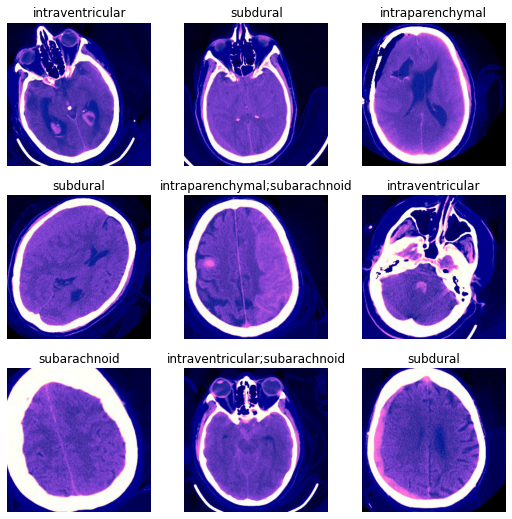

In [10]:
dls.show_batch()

In [11]:
len(dls.train_ds), len(dls.valid_ds), dls.bs

(77633, 19408, 64)

In [12]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.5), model_dir = '/kaggle')

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


SuggestedLRs(lr_min=0.010000000149011612, lr_steep=0.033113110810518265)

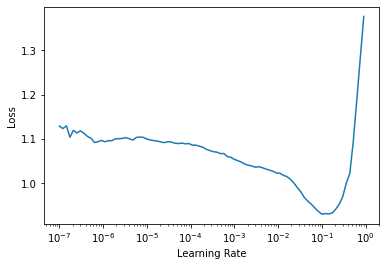

In [13]:
learn.lr_find()

In [14]:
learn.fine_tune(5, base_lr= 3e-2)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.358007,0.332270,0.855667,08:25


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.315283,0.298902,0.874516,09:36
1,0.287316,0.284012,0.884202,09:35
2,0.254762,0.244097,0.899413,09:35
3,0.209392,0.220108,0.910356,09:36
4,0.170776,0.215650,0.913057,09:35


In [15]:
learn.save("/kaggle/working/multilabel-res50-stage-1")

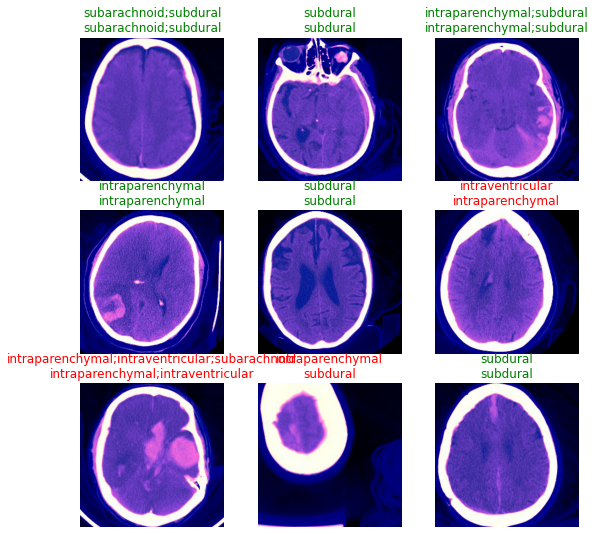

In [16]:
learn.show_results()

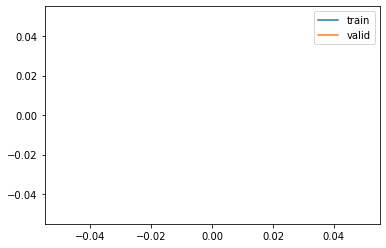

In [17]:
learn.recorder.plot_loss()

SuggestedLRs(lr_min=2.7542287170945203e-07, lr_steep=6.309573450380412e-07)

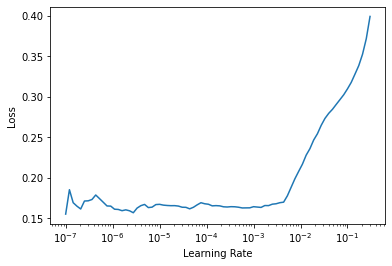

In [18]:
learn.lr_find()

In [19]:
learn.fine_tune(3, base_lr = 9e-6)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.162876,0.216416,0.913180,07:41


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.168426,0.216455,0.913036,09:50
1,0.165717,0.216854,0.912469,09:35
2,0.159434,0.216079,0.912923,09:35


In [20]:
learn.save("/kaggle/working/multilabel-res50-stage-2")

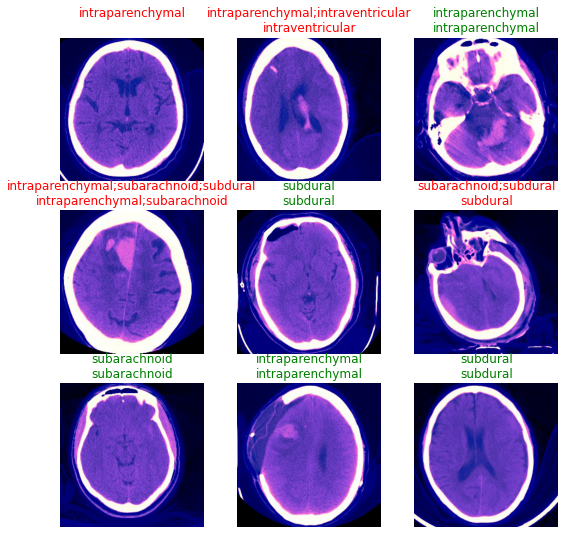

In [21]:
learn.show_results()